# Chicago Crime Data

Data taken from https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

## Import Libraries

In [1]:
from os.path import isfile #check if a file is present
from warnings import filterwarnings #to ignore warnings during SARIMAX parameter computation
from math import inf #infinity
from itertools import product #like meshgrid
from urllib.request import urlretrieve #to download files
import pandas as pd #pandas, for time series and dataframes
import statsmodels.api as sm #needed for SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose #decompose time series into seasonal/trend/residual
from matplotlib import pyplot as plt #plotting
import seaborn as sns #pretty plots

#make figures in line, not a new page
%matplotlib inline

## Read in Data
Here, the crime data is imported from the web. The .csv formatted version of the data is not streamable from the web, so it must be downloaded. If you already downloaded the file, move it to the same directory as this notebook. The number of crimes per day is tabuled and converted to a histogram of average daily crime for each month.

In [2]:
crimefile='Crimes_-_2001_to_present.csv' #Name of the crime .csv file
summaryfile='alldata.csv' #name of daily crime file

#If the .csv file is not in the current directory, download it
url='https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD'
if not isfile(summaryfile):
    if not isfile(crimefile):
        urlretrieve(url, crimefile)  

    #Create a time series of all zeros, to store the counts of daily crime data
    now=pd.datetime.now()
    today='{}-{}-{}'.format(now.year,now.month,now.day) #this is today's date
    ts = pd.Series(0, index = pd.date_range(start='2001-01-01', end = today)) #the zero-valued time series

    #Read the data in chunks
    reader = pd.read_csv(crimefile, usecols=['Date'], chunksize=100000)
    for chunk in reader: #iterate over the chunks
        dailycrimes=pd.to_datetime(chunk['Date']).dt.date.value_counts() #number of crimes in each day in the chunk
        
        # add the daily crime counts from the chunk to ts, our running total of daily crime counts
        for crimedate, crimecount in dailycrimes.iteritems():
            ts[crimedate]+=crimecount 

    #The data set is always missing the data from the few most recent days. Drop them from ts
    ts=ts[ts!=0]

    #Save the daily crime data as a .csv for faster re-use in future runs
    ts.to_csv(summaryfile)        
else:
    ts=pd.read_csv(summaryfile, header=None, index_col=0)
    ts.index=pd.to_datetime(ts.index) #change the index to datetime format
    ts=ts.iloc[:,0]    
ts_mean=ts.resample('M').mean() #average daily crime per month

## Initual Data Visualization
Visualize the data set to make informative decisions when constructing a predictive time-series model. It appears that crime is seasonal, with mid-year peaks.

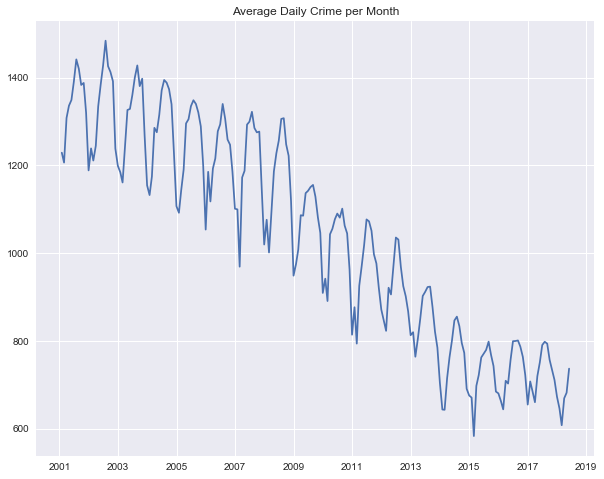

In [3]:
plt.rcParams["figure.figsize"] = (10,8) #set the default figure size

sns.set() #use seaborn-style plots
fig, ax = plt.subplots()
ax.plot(ts_mean)
ax.set_title('Average Daily Crime per Month')
plt.show()

## Seasonal Decomposition
Visually analyze trends by decomposing the data into seasonal and trend components. Limit analysis to the last 6 full years (2012 through 2017)

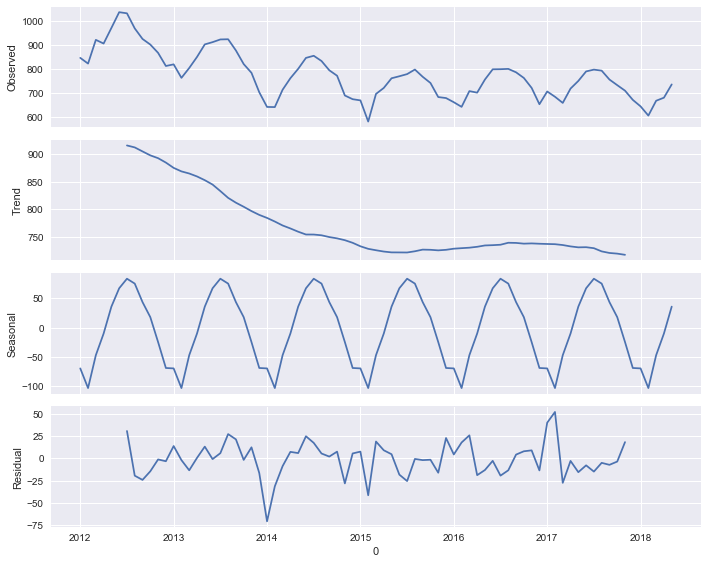

In [4]:
starttime='2012-01'
mdl_data=ts_mean.loc[starttime:]
decomp = seasonal_decompose(mdl_data, model='additive')
fig=decomp.plot()
plt.show()

## Find the optimal seasonal ARIMA model to use


In [5]:
def sarimax_order(data, S=12,
                  p_vals=range(0,2), d_vals=range(0,2), q_vals=range(0,2),
                 P_vals=range(0,2), D_vals=range(0,2), Q_vals=range(0,2)):
    pdq_all = list(product(p_vals, d_vals, q_vals)) #a list of all possible (p,d,q) values
    PDQ_all= list(product(P_vals, D_vals, Q_vals))
    PDQS_all= [(PDQ[0], PDQ[1], PDQ[2], 12) for PDQ in PDQ_all]
    aic=inf
    filterwarnings("ignore") # ignore warning messages

    # Test all possible values of pdq and PDQ
    for pdq in pdq_all:
        for PDQS in PDQS_all:
            try:
                #build a model with a given pdq, PDQ
                guess = sm.tsa.statespace.SARIMAX(data, order=pdq, seasonal_order=PDQS,
                                                   enforce_stationarity=False, enforce_invertibility=False)
                guess_results=guess.fit()
       
                #if the guessed model is better than the previous best model, it is the new best model
                if guess_results.aic<aic: 
                    aic=guess_results.aic
                    order=pdq
                    seasonal_order=PDQS
            except:
                continue #if a model can't be fit, just ignore it
    return (order, seasonal_order,aic)
order, seasonal_order, aic=sarimax_order(mdl_data)
p, d, q = order
P, D, Q, S = seasonal_order
print('ARIMA ({},{},{})x({},{},{}){}'.format(p,d,q,P,D,Q,S))
print('AIC: {}'.format(aic))

ARIMA (0,1,1)x(0,1,1)12
AIC: 477.93140346052263


## Fit seasonal ARIMA model to the training data
Fit a model, treating all 2018 data as out-of-sample 'testing' data.

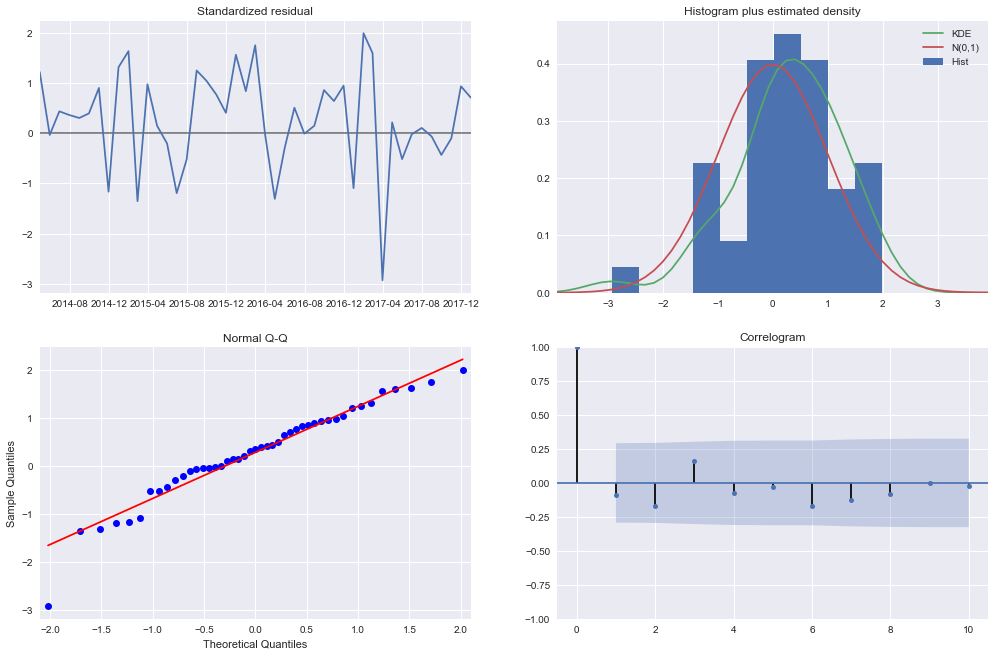

                                 Statespace Model Results                                 
Dep. Variable:                                  1   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -214.019
Date:                            Sun, 27 May 2018   AIC                            434.039
Time:                                    08:01:05   BIC                            439.459
Sample:                                01-31-2012   HQIC                           436.059
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5007      0.112     -4.490      0.000      -0.719      -0.282
ma.S.L12      -0.5253      0.186   

In [6]:
train=ts_mean.loc[starttime:'2017-12'] #take all data prior to 2018 to be 'training' data

#build the model using the previously discovered parameters
mdl=sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order,
                             enforce_stationarity=False, enforce_invertibility=False)
results = mdl.fit()
#Show the regression diagnostics
results.plot_diagnostics(figsize=(17, 11))
plt.show()

#Show the model summary table
print(results.summary())

# Model Predictions
Visualize the model fit for both the training data, and the predicted fit for 2018.
Note: statsmodels lacks the ability to add prediction intervals on forecasted seasonal ARIMA data.

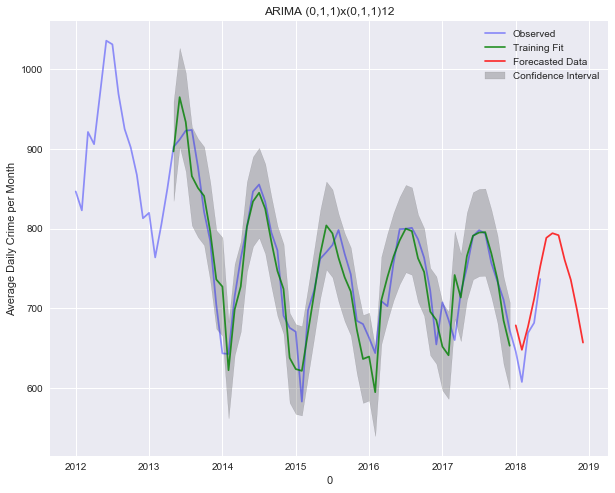

Sum of squared forecast errors: 3909.9274333668727


In [7]:
#plot the observed data
ax = mdl_data.plot(label='Observed', color='b',alpha=.4)
ax.set_ylabel('Average Daily Crime per Month')
ax.set_title('ARIMA ({},{},{})x({},{},{}){}'.format(p,d,q,P,D,Q,S))

#calculate and plot the values fitted from the training data
trainfit=results.get_prediction(start=S+4)
trainfit.predicted_mean.plot(ax=ax, label='Training Fit', color='g', alpha=.8)

#plot the confidence intervals
trainfit_ci = trainfit.conf_int()
ax.fill_between(trainfit_ci.index,
                trainfit_ci.iloc[:, 0],
                trainfit_ci.iloc[:, 1], color='k', alpha=.2, label = 'Confidence Interval')

#calculate and plot the forecasted values for 2018
testfit=results.forecast(steps=12)
testfit.plot(ax=ax, label='Forecasted Data', color='r', alpha=.8)

plt.legend() #show the legend
plt.show()

test=ts_mean['2018-01':] 
ft=testfit[test.index] #compare with the forecasted values of for the known months of 2018

sumsq = sum((test - ft) **2)

print('Sum of squared forecast errors: ' + str(sumsq))